&nbsp;

# 2. Base Models
Whenever conducting empirical testing, it is always a good idea to have a point of reference to compare against, this can come in the form of a benchmark. A benchmark is something that serves as a standard by which others may be measured or judged. In the world of machine learning, benchmarks don’t have to consist of world class models, on the contrary a good starting point is always the default algorithms. The point of having a benchmark is to test out our hypotheses to analyze whether our assumptions measure up and perform the way we hypothesize.

In [1]:
# Standard libraries. 
import pandas as pd
import numpy as np 
import os
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Importing functions. 
import plot_functions

# Importing models. 
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

# Importing transformers. 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Converts plotly output into static images, so it can be viewed inside github repository. 
import plotly.io as pio
pio.renderers.default = "svg"

In [2]:
root = os.getcwd() # Setting root directory as cwd. 
df = pd.read_csv(r"{}\train_new_features.csv".format(root)) # Importing the train set.
df.set_index("Name", inplace=True)
df.head(2)

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Age Group,Martial Status,Survived
Name,,,,,,,,,,,
"Braund, Mr. Owen Harris",3,male,22.0,1,0,A/5 21171,7.2500,S,young adult,Not Married,0
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",1,female,38.0,1,0,PC 17599,71.2833,C,middle aged,Married,1


&nbsp;

### Section A: Base Model Testing
In this section we will be exploring a variety of Machine Learning algorithms and how well they perform with our newly processed data. We'll pick out the top 3 best performing models and use them as our benchmarks, when conducting hypotheses. As mentioned earlier, we are dealing with an imbalanced dataset, so the scoring metric we'll focus on is the f1_score.

Furthermore, we'll be constructing a pipeline with applied steps. Since we're dealing with two different data types (numerical and categorical) we will create a ColumnTransformer object that will enable us to apply different transformers to specific feature data types. Because for example, it wouldn't make sense to OneHotEncode a numerical feature. 

**A.1: Splitting Numerical & Categorical Features**<br>
Our first step before constructing our pipeline estimator is to categorize our features into either "numerical" or "categorical".

In [3]:
# Separating our numerical & categorical columns for ColumnTransformer. 
numerical = list(df.select_dtypes(['float64']).columns)
print(f'Numerical columns are: {numerical}')

categorical = list(df.select_dtypes(exclude=['float64']).columns)
categorical.remove("Survived") # Remove label from data. 
print(f'Categorical columns are: {categorical}')

Numerical columns are: ['Age', 'Fare']
Categorical columns are: ['Pclass', 'Sex', 'SibSp', 'Parch', 'Ticket', 'Embarked', 'Age Group', 'Martial Status']


**A.2: Constructing our Pipeline**<br>
As mentioned earlier, specific transforms such as OHE are only suitable for categorical data, so we need to utilize a ColumnTransformer which gives us the ability to apply certain steps to specific data types. We'll then combine and apply this step into our final pipeline just before adding in our model.

In [4]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

models, results = list(), list()
modelNames = ['CART', 'LR', 'Per', 'KNN', 'RFC', 'GBC', 'XGBC', 'SVC']
modelInstance = [DecisionTreeClassifier(), LogisticRegression(max_iter=1000), Perceptron(), KNeighborsClassifier(), 
                 RandomForestClassifier(), GradientBoostingClassifier(), XGBClassifier(), SVC()]

modelScores = {}

# Storing the model name and instance inside as tuples inside a list. 
for name, model in zip(modelNames,modelInstance):
    # Define categorical pipeline.
    cat_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

    # Define numerical pipeline
    num_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='median'))])

    # Combine categorical and numerical pipelines.
    preprocessor = ColumnTransformer([
        ('cat', cat_pipe, categorical),
        ('num', num_pipe, numerical)])

    # Fit a pipeline with transformers and an estimator to the training data.
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        (name, model)])

    # StratifedKFold preserves the distribution of the population with each sample fold. 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = cross_validate(pipe, X, y, cv=cv, scoring='f1_weighted', return_train_score=True)
    results.append(cv_results['test_score'])
    print("%s scored an f1 train score of: %.4f%% and a test score of: %.4f%%" % (name, 
                                                                                  cv_results['train_score'].mean()*100, 
                                                                                  cv_results['test_score'].mean()*100))
    
    # Storing results to use as benchmark values.
    modelScores[name] = round(cv_results['test_score'].mean()*100,4)

CART scored an f1 train score of: 99.8034% and a test score of: 82.5854%
LR scored an f1 train score of: 88.5457% and a test score of: 81.6441%
Per scored an f1 train score of: 62.1870% and a test score of: 61.9638%
KNN scored an f1 train score of: 79.3820% and a test score of: 71.1578%
RFC scored an f1 train score of: 99.8035% and a test score of: 82.4691%
GBC scored an f1 train score of: 85.3599% and a test score of: 81.3014%
XGBC scored an f1 train score of: 97.1543% and a test score of: 81.4177%
SVC scored an f1 train score of: 64.3767% and a test score of: 63.5922%


**A.3: Table of Results**<br>
Based on the results, the three models I will choose are: Logistic Regression, Gradient Boosting Classifier and the XGB Classifier.

| Model | Train f1_score | Validation f1_score | Overfit | Accept Model |
|---------|---------|---------|---------|---------|
| **Decision Tree** | 99.80% | 83.10% |✔️ |❌ |
| **Logistic Regression** | 88.55% | 81.64% |❌ |✔️ |
| **Perceptron** | 62.19% | 61.96% |❌ |❌ |
| **K Neighbors Classifier** | 79.38% | 71.16% |❌ |❌ |
| **Random Forest Classifier** | 99.80% | 81.91% |✔️ |❌ |
| **Gradient Boosting Classifier** | 85.24% | 81.43% |❌ |✔️ |
| **XGBoost Classifier** | 97.15% | 81.42% |✔️ |✔️ |
| **Support Vector Classifier** | 64.38% | 63.59% |❌ |❌ |

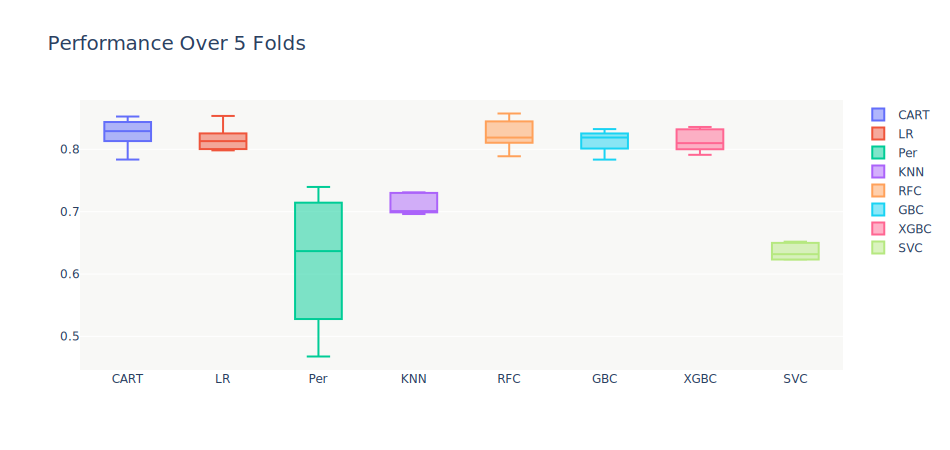

In [5]:
# Plotting distribution of fold results from kfold. 
plot_functions.kfold(scores=results)

&nbsp;

&nbsp;
**Author:** Aaron Chew&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Date Published:** 11/08/2022 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|** &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Email:** aaronsamuelchew@gmail.com &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**|**&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **GitHub:** https://github.com/aaron-chew  